In [2]:
import os
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

Patient with ID 106 have been dropped!!!


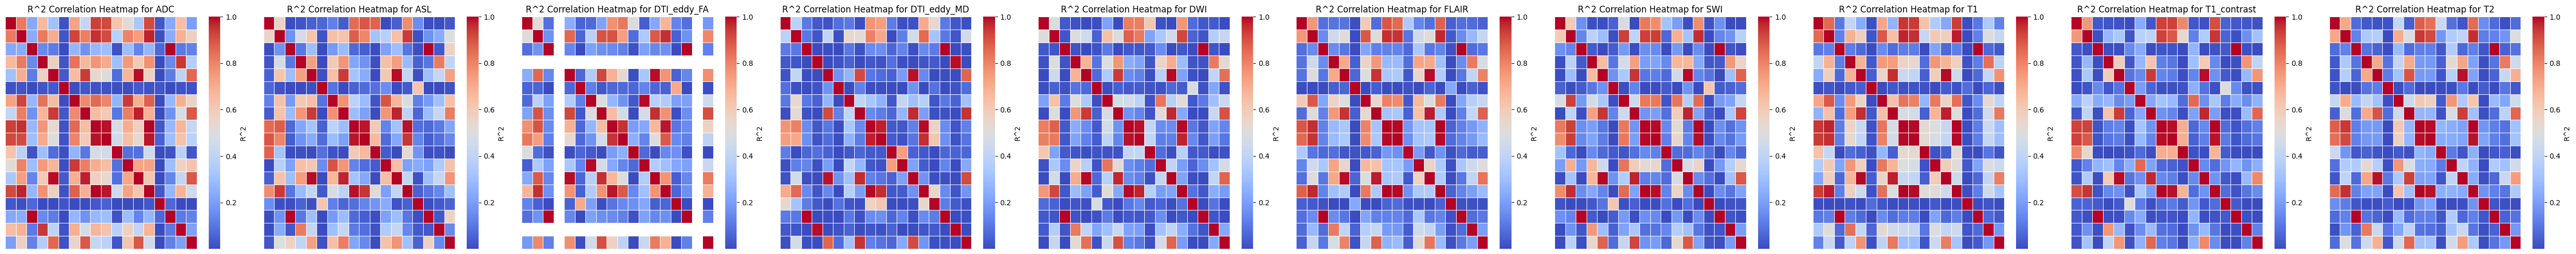

In [6]:
def clean_data(data):
    # Get a list of patient IDs with NaN values
    patients_to_drop = data.loc[data.isnull().any(axis=1)].index.tolist()
    
    return patients_to_drop

def calculate_pairwise_r2_correlation_grouped(feature_data, group_col):
    grouped_data = feature_data.groupby(group_col)

    r2_dfs = {}
    for group, data in grouped_data:
        feature_names = data.columns.drop(group_col)
        n_features = len(feature_names)

        # Initialize an empty array to store the R^2 values
        r2_matrix = np.zeros((n_features, n_features))

        # Calculate R^2 for each pair of features
        for i in range(n_features):
            for j in range(n_features):
                r2_matrix[i, j] = pearsonr(data.iloc[:, i], data.iloc[:, j])[0] ** 2

        # Convert the R^2 array into a DataFrame
        r2_df = pd.DataFrame(r2_matrix, columns=feature_names, index=feature_names)
        r2_dfs[group] = r2_df

    return r2_dfs

def show_heatmaps(data_dict):
    n_heatmaps = len(data_dict)
    fig, axes = plt.subplots(1, n_heatmaps, figsize=(5 * n_heatmaps, 5), dpi=100)

    for idx, (group, data) in enumerate(data_dict.items()):
        ax = axes[idx]
        sns.heatmap(data, annot=False, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"label": "R^2"}, ax=ax,yticklabels=False, xticklabels=False)
        ax.set_title(f"R^2 Correlation Heatmap for {group}")

    plt.tight_layout()
    plt.show()

    # Save the heatmap to a file
    filename = os.path.expanduser('~/Desktop/heatmap_all.png')
    fig.savefig(filename, dpi=300)
    plt.close(fig)


def main():
    folder_path = "/Users/Gabriel/Desktop/MSc_Dissertation/pyRadiomics/extracted_features"

    # Iterate through all CSV files in the folder and store them in a list of DataFrames
    dataframes = []
    patients_to_drop = set()  # Initialize patients_to_drop before the loop
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)

            # Extract the identifier from the file name
            identifier = file[len("extracted_firstorder_features_"):-len(".csv")]

            # Read the file into a DataFrame and add the 'MRI_sequence' column
            df = pd.read_csv(file_path, index_col=0)
            df['MRI_sequence'] = identifier
            
            # Find the patients to drop for this DataFrame
            patients_to_drop.update(clean_data(df))
            dataframes.append(df)
            
    # !!! patient 106 had nan in original_firstorder_RobustMeanAbsoluteDeviation - dropped patient
    for patient_to_drop in patients_to_drop:
        for df in dataframes:
            if patient_to_drop in df.index:
                df.drop(patient_to_drop, inplace=True)

    print(f"Patient with ID {patient_to_drop} have been dropped!!!")

    # Concatenate all DataFrames in the list into a single DataFrame
    feature_data = pd.concat(dataframes, axis=0)

    # Calculate the pairwise R^2 correlation within each group identified by the 'MRI_sequence' column
    r2_dfs_grouped = calculate_pairwise_r2_correlation_grouped(feature_data, 'MRI_sequence')

    # Visualize R^2 correlation heatmaps for each group
    show_heatmaps(r2_dfs_grouped)
    
if __name__ == "__main__":
    main()

In [34]:
pd.options.display.max_rows = 400

In [ ]:
# def calculate_correlation_between_r2(r2_df1, r2_df2):
#     assert r2_df1.shape == r2_df2.shape, "Both R^2 DataFrames must have the same dimensions."

#     feature_names = r2_df1.columns
#     n_features = len(feature_names)

#     correlation_matrix = np.zeros((n_features, n_features))

#     for i in range(n_features):
#         for j in range(n_features):
#             correlation_matrix[i, j] = pearsonr(r2_df1.iloc[i, j], r2_df2.iloc[i, j])[0]

#     correlation_df = pd.DataFrame(correlation_matrix, columns=feature_names, index=feature_names)
#     return correlation_df